<h1 align='center'>Machine Learning Lab</h1>
<h3 align='center'>Lab 08</h3>

### Exercise 1: Optical Character Recognition via Neural Networks

#### Importing Packages

In [1]:
import pandas as pd                                       #Importing Pandas
import numpy as np                                        #Importing Numpy
from sklearn.datasets import load_digits                  #Importing MNIST Dataset from Sklearn
import matplotlib.pyplot as plt                           #Importing Matplotlib
from sklearn.model_selection import train_test_split      #Importing Train test Split
from sklearn.neural_network import MLPClassifier          #Importing MLP Classifier
from sklearn.model_selection import RandomizedSearchCV    #Importing Randomized Search
from sklearn.metrics import accuracy_score                #Importing Accuracy Score

#### Initializing Random Seed

In [2]:
random_seed = 3116

#### Loading the MNIST digits dataset via sklearn provided built-in utility function(s).

In [3]:
mnist_digits = load_digits()

##### Plotting the Initial 10 Handwritten Digits from the Dataset

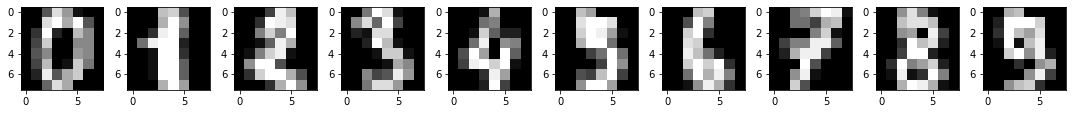

In [4]:
#Creating a Figure
fig = plt.figure(figsize=(15, 10))

#Iterating through the first 10 handwritten digits from the dataset
for i in range(1, 11):
    #Adding a subplot
    plt.subplot(1, 10, i)
    
    #Plotting the Image in Grayscale
    plt.imshow(mnist_digits.images[i - 1], cmap = 'gray')
    
#Adjusting Spacing and Showing the plots
plt.tight_layout()
plt.show()

#### K-cross Fold Validation and Train Test Split

##### Initializing the value of k for K-cross fold validation

In [5]:
k = 5

##### Splitting the Dataset into Train and Test with 20% Testing set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(mnist_digits.data, mnist_digits.target, test_size = 0.2, random_state = random_seed)

#### Defining a hyperparameter grid for the MLP Classifier

In [7]:
hyperparameter_grid = {
    'hidden_layer_sizes': [(10,), (10,20), (10,20,10)],             #The number of neurons in each hidden layer
    'activation': ['identity', 'logistic', 'tanh', 'relu'],         #Activation function for the hidden layer
    'solver': ['lbfgs', 'sgd', 'adam'],                             #Weight Optimization techniques
    'alpha': [0.5, 0.01, 0.001, 0.0001,],                           #L2 Regularization term 
    'learning_rate': ['constant', 'invscaling', 'adaptive']         #Learning rate schedule for weight updates
}

#### Defining a Random Search procedure over the ranges of Hyperparameters above

In [8]:
#Creating the object of MLP(Multi Layer Perceptron) Classifier with maximum iteration of 100
mlp = MLPClassifier(max_iter = 100, random_state = random_seed)

#Creating and Initializing the object for Randomized Search with the MLP Classifier and the hyperparameter grid
rand_mlp = RandomizedSearchCV(mlp, hyperparameter_grid, random_state = random_seed, n_jobs = -1,n_iter = 20, cv = k, scoring = 'accuracy')

#Fitting the training dataset on the MLP Classifier using Randomized Search for finding the best hyperparameters
rand_mlp.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(max_iter=100, random_state=3116),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [0.5, 0.01, 0.001, 0.0001],
                                        'hidden_layer_sizes': [(10,), (10, 20),
                                                               (10, 20, 10)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   random_state=3116, scoring='accuracy')

#### Reporting the test accuracy and the best hyperparameters found

##### Best Hyperparameters Found

In [9]:
print('The Best Hyperparameter Combination is:')
rand_mlp.best_params_

The Best Hyperparameter Combination is:


{'solver': 'lbfgs',
 'learning_rate': 'constant',
 'hidden_layer_sizes': (10, 20, 10),
 'alpha': 0.0001,
 'activation': 'identity'}

##### Test Accuracy

In [10]:
print('The Test Accuracy of MLP Classifier with best Hyperparameters is: {:.2f}'.format(accuracy_score(y_test, rand_mlp.predict(X_test))))

The Test Accuracy of MLP Classifier with best Hyperparameters is: 0.96


### Exercise 2: End-to-End Self-Driving via Convolutional Neural Networks

#### Importing Packages

In [11]:
import torch                                              #Importing torch
from torch.utils.data import DataLoader , Dataset         #Importing Dataloader and Dataset from pytorch
import torchvision                                        #Importing Torchvision
from torch.utils.data import random_split                 #Importing Random Split from pytorch
import torch.nn.functional as F                           #Importing Activation Functions from pytorch
from torch import nn                                      #Importing Neural Network helper functions from nn package of pytorch
import cv2                                                #Importing Opencv
import numpy as np                                        #Importing Numpy
import matplotlib.pyplot as plt                           #Importing Matplotlib

C:\Users\dell\anaconda3\envs\ml_lab\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\dell\anaconda3\envs\ml_lab\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


#### Class to load Dataset containing data and its labels

In [12]:
class Dataset(Dataset):#Inherits from torch.utils.data.Dataset
    
    #Constructor Function which read image names and its label from the directory
    def __init__(self):
        #default directory where data is loaded
        self.filepath = 'archive/driving_dataset/'
        
        #default directory where labels for each image is saved
        self.filepath_angles = 'archive/driving_dataset/angles.txt'
        
        #Creating lists for storing filenames and its label(steering angle)
        self.filenames = []
        self.steering_angle = []
        
        #Opening the angles file and saving the filenames and angles in the created lists
        with open(self.filepath_angles) as angles:
            line = angles.readline()
            while line:
                tokens = line.split()
                self.filenames.append(tokens[0])
                self.steering_angle.append(tokens[1])
                line = angles.readline()
    
    #Function to return the total datapoints in the dataset
    def __len__(self):
        return len(self.filenames)
    
    #Function to get the image and its label at specified index
    def __getitem__(self, index):
        #Extracting filename and angle from the list
        filename = self.filenames[index]
        angle = self.steering_angle[index]
        
        #Reading the image using opencv
        img = cv2.imread(self.filepath + filename)
        
        #Resizing images to(32,32)
        resized = cv2.resize(img, (200, 66),interpolation = cv2.INTER_AREA)
        
        #return the image converted to a numpy array its corresponding steering angle
        return torch.from_numpy(resized.transpose()).float(), torch.tensor(np.float32(angle))

#### Class which Implements the Convolutional Neural Network Architecture proposed in the paper

In [13]:
class ConvNet(torch.nn.Module):
    
    #Constructor function which list all the layers in CNN model
    def __init__(self):
        super().__init__()
        self.norm1 = nn.LayerNorm([200,66])
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 24, kernel_size = 5, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 24, out_channels = 36, kernel_size = 5, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 36, out_channels = 48, kernel_size = 5, stride = 2)
        self.conv4 = nn.Conv2d(in_channels = 48, out_channels = 64, kernel_size = 3, stride = 1)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1)
        self.fc1 = nn.Linear(in_features = 64 * 1 * 18, out_features = 100)
        self.fc2 = nn.Linear(in_features = 100, out_features = 50)
        self.fc3 = nn.Linear(in_features = 50, out_features = 10)
        self.fc4 = nn.Linear(in_features = 10, out_features = 1)
        
    #Function to link all the layers in the sequence
    def forward(self, x):
        x = self.norm1(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### Dividing the dataset into corresponding train/validation/test splits. Leaving the last 10k images for testing.

In [14]:
#Creating the Dataset object
car_dataset = Dataset()

#Total rows to be included in Test set
test_rows = 10000

#Total rows to be included in Validation set
train_rows = car_dataset.__len__() - test_rows
val_rows = int(train_rows * 0.2)

#Total rows to be included in training set
train_rows -= val_rows

#Splitting the dataset into Train/Validation/Test sets using Pytorch Random Split function
train_dataset, val_dataset, test_dataset = random_split(car_dataset, [train_rows, val_rows, test_rows], 
                                                        generator=torch.Generator().manual_seed(random_seed))

##### Converting the Datasets into Dataloaders for Iterations

In [15]:
#Train Dataloader
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

#Validation Dataloader
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

#Test Dataloader
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

#### Training and Evaluating the CNN on the dataset Sets

##### Checking for GPU, if present then changing device to Cuda

In [16]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
torch.device(device)

device(type='cuda')

##### Creating the Object of our CNN model and transferring it to the Device

In [17]:
model = ConvNet().to(device)
model

ConvNet(
  (norm1): LayerNorm((200, 66), eps=1e-05, elementwise_affine=True)
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

##### Initiating the RMSE Loss function and the ADAM optimizer

In [18]:
#Creating the RMSE loss function object provided in Pytorch
criterion = nn.MSELoss()

#Creating the Adam Optimizer object with model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [19]:
#Initializing the number of Epochs
epochs = 30

#Creating list to store the RMSE of Training and Validation dataset in each Epochs
training_rmse = []
validation_rmse = []

##### Training the model and Evaluating it on the Validation dataset

In [20]:
#Iterating over all Epochs
for e in range(epochs):
    
    #Initiating the training and validation loss to 0
    running_loss = 0.0
    val_running_loss = 0.0
    
    #Iterating over all Training datapoints
    for inputs, labels in train_dataloader:
        
        #Extracting Input image and label and doing a forward pass on our CNN model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        #Calculating the RMSE loss
        loss = criterion(outputs, labels)
        
        #Setting the gradient to Zero for next Iteration
        optimizer.zero_grad()
        
        #Computing the Back propogation on CNN
        loss.backward()
        optimizer.step()
        
        #Adding the RMSE loss to the total loss
        running_loss += loss.item()
    
    #Evaluating the model on the Validation set
    with torch.no_grad():
        
        #Iterating over the validation dataset
        for val_inputs, val_labels in val_dataloader:
            
            #Extracting Input image and label and doing a forward pass on our CNN model
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            
            #Calculating the RMSE loss
            val_loss = criterion(val_outputs, val_labels)
            
            #Adding the RMSE loss to the total validation loss
            val_running_loss += val_loss.item()
    
    #Calculating the current Epoch average RMSE loss on training and Validation dataset
    epoch_loss = np.sqrt(running_loss/len(train_dataloader))
    val_epoch_loss = np.sqrt(val_running_loss/len(val_dataloader))
    
    #Apending the loss in the final list
    training_rmse.append(epoch_loss)
    validation_rmse.append(val_epoch_loss)
    
    #Printing the Results
    print('epoch :', (e+1))
    print('training loss: {:.4f}'.format(epoch_loss))
    print('validation loss: {:.4f}'.format(val_epoch_loss))

C:\Users\dell\anaconda3\envs\ml_lab\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dell\anaconda3\envs\ml_lab\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dell\anaconda3\envs\ml_lab\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

epoch : 1
training loss: 30.7713
validation loss: 30.6681
epoch : 2
training loss: 30.8140
validation loss: 30.6546
epoch : 3
training loss: 30.7403
validation loss: 30.7443
epoch : 4
training loss: 30.7487
validation loss: 30.6669
epoch : 5
training loss: 30.7302
validation loss: 30.6170
epoch : 6
training loss: 30.7283
validation loss: 30.6350
epoch : 7
training loss: 30.7212
validation loss: 30.6243
epoch : 8
training loss: 30.7345
validation loss: 30.6251
epoch : 9
training loss: 30.7226
validation loss: 30.6772
epoch : 10
training loss: 30.7315
validation loss: 30.6287
epoch : 11
training loss: 30.7257
validation loss: 30.6631
epoch : 12
training loss: 30.7104
validation loss: 30.6013
epoch : 13
training loss: 30.7099
validation loss: 30.5996
epoch : 14
training loss: 30.7055
validation loss: 30.6503
epoch : 15
training loss: 30.7067
validation loss: 30.6314
epoch : 16
training loss: 30.7075
validation loss: 30.6021
epoch : 17
training loss: 30.7182
validation loss: 30.6359
epoch 

##### Plotting Training RMSE vs Validation RMSE in each Epoch

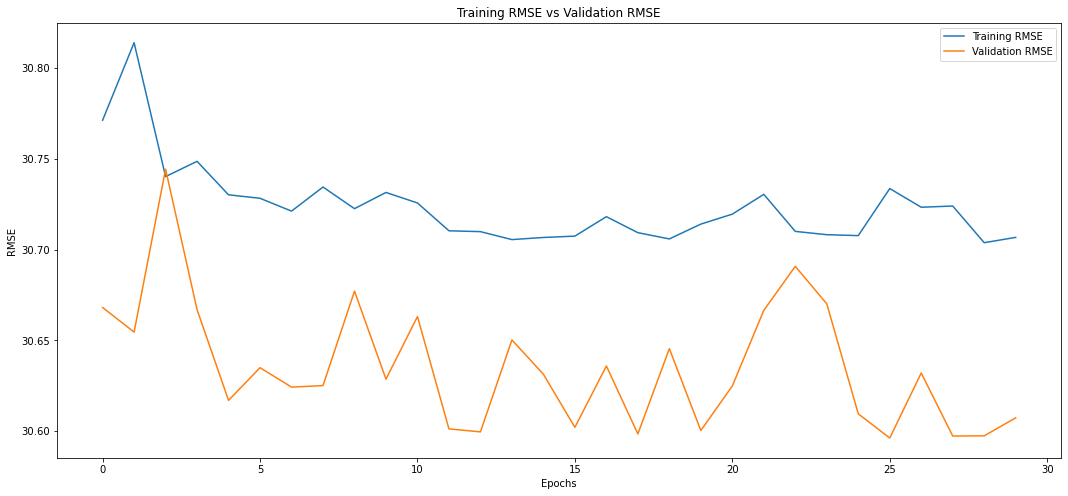

In [21]:
fig = plt.figure(figsize=(18,8))
plt.plot(training_rmse, label = 'Training RMSE')
plt.plot(validation_rmse, label = 'Validation RMSE')
plt.title('Training RMSE vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

##### Evaluating the Trained CNN Model with the Test Dataset

In [22]:
#Initializing the loss to 0
running_loss = 0.0

#Evaluating the model on the Test set
with torch.no_grad():

    #Iterating over the Test dataset
    for inputs, labels in test_dataloader:

        #Extracting Input image and label and doing a forward pass on our CNN model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        #Calculating the RMSE loss
        loss = criterion(outputs, labels)

        #Adding the RMSE loss to the total Test loss
        running_loss += loss.item()

#Calculating the current Epoch average RMSE loss on Test dataset
epoch_loss = np.sqrt(running_loss/len(test_dataloader))

C:\Users\dell\anaconda3\envs\ml_lab\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [23]:
print('Test RMSE: {:.4f}'.format(epoch_loss))

Test RMSE: 31.6328
